In [1]:
import sys
sys.path.append('../..')
sys.path.append('../../../../transformer_pytorch')
%load_ext autoreload
%autoreload 2

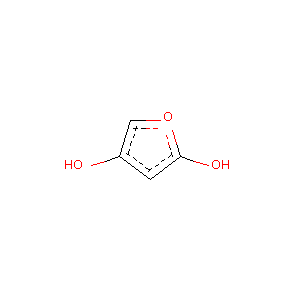

In [2]:

from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors
from rdkit.Chem.Draw import MolToImage, MolToFile, _moltoSVG, MolsToGridImage

smile1 = 'c1nnnc2c1nnn2'
smile7 = 'c1cnnc2n1ncc2'
smile6 = 'c1cncc2n1ccc2'
smile2='OC(=O)O'
smile3 ='c1cccc1'
smile4 = 'C(=C=Nc1c(c2c(OOI)cncn2)nc(Br)c2n1c(I)c(OO)c2)'
smile5 = 'C(OS(=O)(=O))C1SNC(c2c(I)c(NN=O)c(c3cc(F)ccc3C#C)cc2Cl)C(=Nc2nc(S(=O)(=O))c(c3nc(C(c4c(C#N)nnc5n4nnn5)F)nc4n3cnc4c3cnncc3N=C(S)c3c(F)cnc(I)n3)c3n2cnn3)N(SI)NC(F)O1'
smile8 = 'Oc1cc(O)oc1'

mol = Chem.MolFromSmiles(smile8)

MolToImage(mol, kekulize=False)

In [3]:
MolToFile(mol, 'test.svg', imageType='svg')

In [4]:
from generative_playground.models.model_settings import get_decoder, get_settings

max_len = 40
settings = get_settings(True, 'new')

# Now let's run a random model with a grammar
model, _ = get_decoder(True,
                    'new',
                    feature_len=settings['feature_len'],
                    max_seq_length=max_len,
                    decoder_type='random',
                   batch_size=9)


smiles ->  C
smiles -> nonH_bond
smiles -> N
smiles -> O
smiles -> aromatic_ring
C -> 'C'   
C -> 'C'   nonH_bond
C -> 'C'  '(' nonH_bond ')' 
C -> 'C'  '(' nonH_bond ')' nonH_bond
C -> 'C' '(' nonH_bond ')'  
C -> 'C' '(' nonH_bond ')'  nonH_bond
C -> 'C' '(' nonH_bond ')' '(' nonH_bond ')' 
C -> 'C' '(' nonH_bond ')' '(' nonH_bond ')' nonH_bond
C -> '[' 'C' chirality 'H' ']'  
C -> '[' 'C' chirality 'H' ']'  nonH_bond
C -> '[' 'C' chirality 'H' ']' '(' nonH_bond ')' 
C -> '[' 'C' chirality 'H' ']' '(' nonH_bond ')' nonH_bond
chirality -> '@'
chirality -> '@' '@'
C -> 'C' '(' double_bond ')' 
C -> 'C' '(' double_bond ')' nonH_bond
C -> 'C' triple_bond
N -> 'N'  
N -> 'N'  nonH_bond
N -> 'N' '(' nonH_bond ')' 
N -> 'N' '(' nonH_bond ')' nonH_bond
N -> 'N' double_bond
N -> 'N' triple_bond
O -> 'O' 
O -> 'O' nonH_bond
O -> 'O' double_bond
double_bond -> '=' 'O'
double_bond -> '=' 'S'
double_bond -> '=' 'N' 
double_bond -> '=' 'N' nonH_bond
double_bond -> '=' 'C'  
double_bond -> '=' 'C' 

['O=CSO', 'C[NH+]', 'Br', 'C', 'O=NOF', 'N', 'N(NS)S', 'N(S)', 'OSN(N[O-])']
[0, 0, 0, 0, 0, 0, 0, 0, 0]


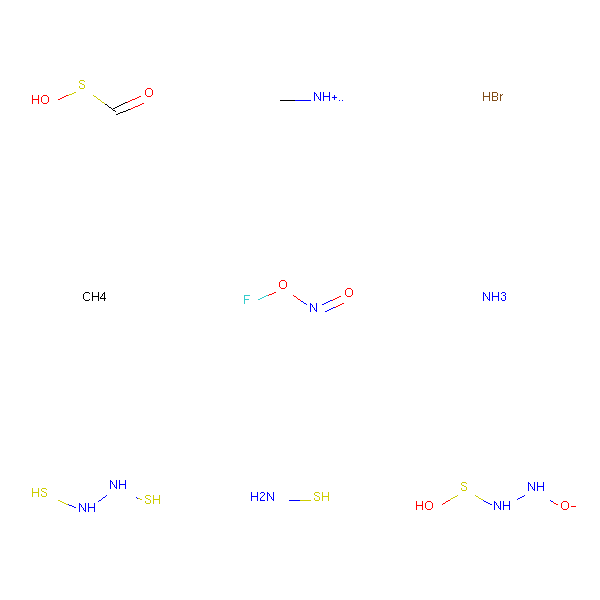

In [5]:
from generative_playground.codec.grammar_codec import GrammarModel
settings = get_settings(True, 'new')
codec = GrammarModel(grammar=settings['grammar'],
                    tokenizer=settings['tokenizer'])
actions = model()[0].detach().cpu().numpy()
#print(actions, settings['feature_len'])
my_smiles = codec.decode_from_actions(actions)
print(my_smiles)

mols = [Chem.MolFromSmiles(my_smile) for my_smile in my_smiles]
print([Descriptors.NumAromaticRings(m) for m in mols if m is not None])
MolsToGridImage(mols, kekulize=False)

In [6]:
#my_smiles.append'c1ccncn1']

def parse(x):
    # print(x)
    try:
        return next(codec._parser.parse(x))
    except Exception as e:
        print('fail!')
        print(e)
        return None
    
tokens = [codec._tokenize(s) for s in my_smiles]
parse_trees = [parse(t) for t in tokens]
print(parse_trees, len(parse_trees))


[Tree('smiles', [Tree('O', ['O', Tree('double_bond', ['=', 'C', Tree('nonH_bond', ['S', Tree('nonH_bond', ['O'])])])])]), Tree('smiles', [Tree('C', ['C', Tree('nonH_bond', ['[', 'N', 'H', '+', ']'])])]), Tree('smiles', [Tree('nonH_bond', ['Br'])]), Tree('smiles', [Tree('C', ['C'])]), Tree('smiles', [Tree('O', ['O', Tree('double_bond', ['=', 'N', Tree('nonH_bond', ['O', Tree('nonH_bond', ['F'])])])])]), Tree('smiles', [Tree('nonH_bond', ['N'])]), Tree('smiles', [Tree('nonH_bond', ['N', '(', Tree('nonH_bond', ['N', Tree('nonH_bond', ['S'])]), ')', Tree('nonH_bond', ['S'])])]), Tree('smiles', [Tree('N', ['N', '(', Tree('nonH_bond', ['S']), ')'])]), Tree('smiles', [Tree('nonH_bond', ['O', Tree('nonH_bond', ['S', Tree('nonH_bond', ['N', '(', Tree('nonH_bond', ['N', Tree('nonH_bond', ['[', 'O', '-', ']'])]), ')'])])])])] 9


In [7]:
fname = '../data/250k_rndm_zinc_drugs_clean.smi'

with open(fname) as f:
    smiles = f.readlines()

for i in range(len(smiles)):
    smiles[i] = smiles[i].strip()


In [13]:
tokens = [codec._tokenize(s) for s in smiles[:100]]
parse_trees = [parse(t) for t in tokens]
nice = [ip for ip, p in enumerate(parse_trees) if p is not None]
print(len(nice), nice)

fail!

fail!

fail!

fail!

fail!

fail!
Grammar does not cover some of the input words: "'/', '/'".
fail!
Grammar does not cover some of the input words: "'/', '/'".
fail!

fail!

fail!

fail!

fail!

fail!

fail!

fail!

fail!

fail!

fail!

fail!

fail!

fail!

fail!

fail!

fail!

fail!

fail!

fail!
Grammar does not cover some of the input words: "'/', '/'".
fail!

fail!
Grammar does not cover some of the input words: "'/', '/'".
fail!

fail!

fail!

fail!

fail!

fail!

fail!

fail!

fail!

fail!

fail!

fail!

fail!

fail!

fail!

fail!

fail!
Grammar does not cover some of the input words: "'/', '/'".
fail!

fail!

fail!
Grammar does not cover some of the input words: "'/', '\\\\'".
fail!

fail!

fail!

fail!

fail!

fail!

fail!

fail!

fail!

fail!

fail!

fail!
Grammar does not cover some of the input words: "'/', '\\\\'".
fail!

fail!

fail!

fail!

fail!

fail!

fail!

fail!

fail!

fail!

fail!

fail!

fail!

fail!

fail!

fail!

fail!

fail!

fail!

fail!

fail!
Grammar 

In [9]:
i = 7

26 CC[C@H](C)C[C@@H](C)NC(=O)N1CCN(CC(=O)NC2CC2)CC1


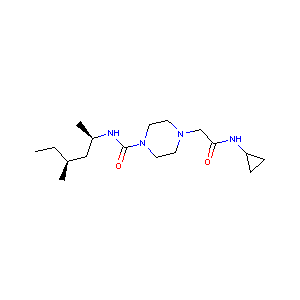

In [32]:
# C[C@@H]1CC(Nc2cncc(-c3nncn3C)c2)C[C@@H](C)C1
#N#Cc1ccc(-c2ccc(O[C@@H](C(=O)N3CCCC3)c3ccccc3)cc2)cc1
#C[C@@H]1CC(Nc2cncc(-c3nncn3C)c2)C[C@@H](C)C1
#smile = 'Nc2cncc(-c3nncn3C)c2'
smile =  smiles[i]
print(i, smile)
mol = Chem.MolFromSmiles(smile)
parse_tree = parse(codec._tokenize(smile))


i+=1
MolToImage(mol, kekulize=False)


In [11]:
# i+=1
# my_smile =smiles[i]
# mols = [Chem.MolFromSmiles(my_smile)]
# print(i, my_smile, [Descriptors.NumAromaticRings(m) for m in mols])
# MolsToGridImage(mols, kekulize=False)


In [12]:

# from generative_playground.models import grammar_ed_models as grammar_model

# # We load the auto-encoder
# grammar_weights = '../pretrained/my_molecules.mdl'
# grammar_model = grammar_model.ZincGrammarModel(grammar_weights)
# z = grammar_model.encode(['c1nccc2n1ccc2'])
# new_smile = grammar_model.decode(z)